# Compute the condition number given the data, as well as the theoretical one

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import jax
import jax.numpy as jnp
from jax import random
from jax.config import config
from tqdm import tqdm

from simplecryoem.emfiles import load_data
from simplecryoem.preprocess import preprocess
from simplecryoem.forwardmodel import Slice
from simplecryoem.optimization import Loss, GradV, get_sgd_vol_ops
from simplecryoem.utils import create_3d_mask

In [2]:
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 6, 6
config.update("jax_enable_x64", True)

### Loading the files, basic preprocessing etc. Identical to the main Higher_stochastic notebook

In [3]:
#data_dir = "../../../daniel/CrossValidationCryodrgnSet/"
data_dir = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/"
star_file = "particles_crossvalidation_train_1.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs=True, fourier=False)

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles: 105519
load_data: data loaded, time:  65.58 sec.


In [4]:
# Extract a subset with fixed seed key so that we always get the same subset.
# Larger sets must be supersets of the smaller sets respectively.

N0 = imgs0.shape[0]
nx0 = imgs0.shape[1]

subset_seed = 60
subset_key = random.PRNGKey(subset_seed)
idx_full = random.permutation(subset_key, N0)

print(subset_key)
print(idx_full[:10])

[ 0 60]
[ 18720  60093  53249 102196  43608  18973  24325  65695  39526  50914]


In [5]:
out_dir = "../../simplecryoem_output/out_dev/"

nx_crop = 192  # 64 #8 #192 # 128 # 64
N = 50000  # 10000 #200 #104000 #80000 # 20000

idx = idx_full[:N]

In [6]:
len(imgs0)

105519

In [7]:
processed_data = preprocess(imgs0, params0, nx_crop=nx_crop, idx=idx)

imgs_f = processed_data["imgs_f"]
angles = processed_data["angles"]
shifts = processed_data["shifts"]
ctf_params = processed_data["ctf_params"]

imgs0.shape = (105519, 320, 320)
pixel_size0.shape = (105519,)
angles0.shape = (105519, 3)
shifts0.shape = (105519, 2)
ctf_params0.shape = (105519, 9)
N0 = 105519
idx provided
N = 50000
Taking FFT of the images:
Batch 1/10  12.67 sec.
Batch 2/10  12.67 sec.
Batch 3/10  12.67 sec.
Batch 4/10  12.67 sec.
Batch 5/10  12.67 sec.
Batch 6/10  12.67 sec.
Batch 7/10  12.67 sec.
Batch 8/10  12.67 sec.
Batch 9/10  12.67 sec.
Batch 10/10  12.67 sec.
FFT done. Time:  155.66 sec.
x_grid = [2.38549618e-03 3.20000000e+02]
new x_grid = [2.38549618e-03 1.92000000e+02]
Vectorised imgs_f.shape = (50000, 36864)
Mask radius = 0.22662213740458012
Noise free, setting sigma_noise = 1


In [8]:
# Assuming these variables are the same for all images

pixel_size = processed_data["pixel_size"]
nx = processed_data["nx"]
mask = processed_data["mask"]
sigma_noise = processed_data["sigma_noise"]
x_grid = processed_data["x_grid"]
N = imgs_f.shape[0]

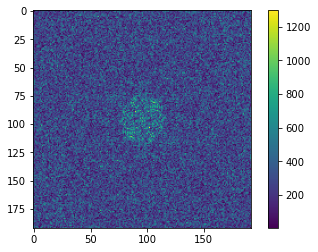

In [9]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[15].reshape([nx_crop, nx_crop]))))
plt.colorbar()

In [10]:
del imgs0

In [11]:
# Apply mask to images

apply_mask = True

if apply_mask:
    # mask2d = mask[0].reshape(-1)
    mask2d = mask[0].reshape(-1)
    imgs_f = imgs_f * mask2d
else:
    mask = jnp.ones(mask.shape)

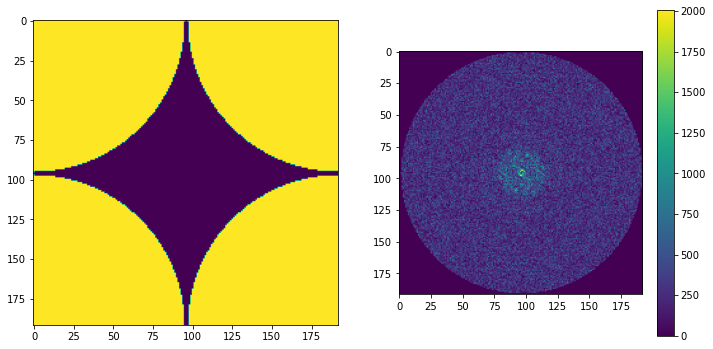

In [12]:
plt.rcParams["figure.figsize"] = 12, 6

plt.subplot(1, 2, 1)
plt.imshow(mask[0])

plt.subplot(1, 2, 2)
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[123].reshape([nx_crop, nx_crop]))))
plt.colorbar()

plt.rcParams["figure.figsize"] = 6, 6

### Some functions to compute the x-axis $p = P_x(r)/P_v(r)$

In [13]:
# Compute number of points in a disk/ball of a given radius.
# The code is similar to the one in the src.fsc.average_shells and src.fsc.average_shells_2d functions
# but counts the points in the full 2D disk/3D ball rather than shells, and res represents
# the upper bounds of the shells, not the midpoints.


def compute_n_pts_2d(grid, dr):
    nx = int(grid[1])
    img = np.zeros((nx, nx))

    # Calculate the radius in the Fourier domain.
    x_freq = np.fft.fftfreq(int(grid[1]), 1 / (grid[0] * grid[1]))
    X, Y = np.meshgrid(x_freq, x_freq)
    r = np.sqrt(X**2 + Y**2)

    # Max radius so that the shells are not outside the
    # rectangular domain.
    max_rad = np.max(r[:, 0])

    # Calculate the shells.
    shell_n_pts = []
    res = []
    R = -dr / 2
    while R + dr <= max_rad:
        cond = r <= R + dr
        shell_n_pts.append(np.sum(cond))
        res.append(R + dr)
        R += dr
    res[0] = 0

    res = np.array(res)
    shell_n_pts = np.array(shell_n_pts)

    return res, shell_n_pts


def compute_n_pts_3d(grid, dr):
    nx = int(grid[1])
    v = np.zeros((nx, nx, nx))

    # Calculate the radius in the Fourier domain.
    x_freq = np.fft.fftfreq(int(grid[1]), 1 / (grid[0] * grid[1]))
    X, Y, Z = np.meshgrid(x_freq, x_freq, x_freq)
    r = np.sqrt(X**2 + Y**2 + Z**2)

    # Max radius so that the shells are not outside the
    # rectangular domain.
    max_rad = np.max(r[:, 0, 0])

    # Calculate the shells.
    shell_n_pts = []
    res = []
    R = -dr / 2
    while R + dr <= max_rad:
        cond = r <= R + dr
        shell_n_pts.append(np.sum(cond))
        res.append(R + dr)
        R += dr
    res[0] = 0

    res = np.array(res)
    shell_n_pts = np.array(shell_n_pts)

    return res, shell_n_pts

### Compute the condition number

In [14]:
alpha = 1e-8  # 1e-9 #1e-5 #1e-9 #1e-9 # 1e-5
interp_method = "nn"

# Use ctf_params0 for to compute the condition number without CTF
ctf_params0 = jnp.array(N * [None]).reshape((N,1))

# slice_obj = Slice(x_grid, mask = mask, interp_method = interp_method)

slice_obj = Slice(x_grid, mask=mask, interp_method=interp_method)
loss_obj = Loss(slice_obj, alpha=alpha)
gradv_obj = GradV(loss_obj)

_, _, hvp_func, _ = get_sgd_vol_ops(
    gradv_obj, loss_obj, angles, shifts, ctf_params, imgs_f, sigma_noise
)

# The same as above but without CTF
_, _, hvp_func0, loss_px_func = get_sgd_vol_ops(
    gradv_obj, loss_obj, angles, shifts, ctf_params0, imgs_f, sigma_noise
)


In [15]:
# Compute the Hessian diagonals exactly (valid for NN interpolation) -
# In batches
# Full diagonal

compute_hess_diag = True

key = random.PRNGKey(62)
key, subkey = random.split(key)
x0 = random.normal(subkey, [nx, nx, nx], dtype=jnp.complex128)

if compute_hess_diag:
    batch_sz = 100
    n_batch = N // batch_sz
    idx_batches = np.array_split(np.arange(N), n_batch)
    ones = jnp.ones(x0.shape, dtype=jnp.complex128)

    D = np.zeros([nx, nx, nx], dtype=np.complex128)
    D0 = np.zeros([nx, nx, nx], dtype=np.complex128)
    for idx in tqdm(idx_batches):
        D += hvp_func(x0, ones, idx)
        D0 += hvp_func0(x0, ones, idx)

    D = jnp.array(D / n_batch)
    D0 = jnp.array(D0 / n_batch)

assert jnp.max(jnp.abs(jnp.imag(D))) < 1e-16
assert jnp.max(jnp.abs(jnp.imag(D0))) < 1e-16

D = jnp.real(D)
D0 = jnp.real(D0)

100%|██████████| 500/500 [01:06<00:00,  7.47it/s]


kappa(H) = 7495699.279941956
kappa(H_noCTF) = 100000001.00000128


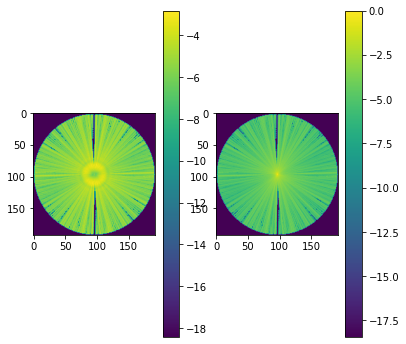

In [16]:
plt.subplot(121)
plt.imshow(jnp.fft.fftshift(jnp.log(D[0])))
plt.colorbar()
plt.subplot(122)
plt.imshow(jnp.fft.fftshift(jnp.log(D0[0])))
plt.colorbar()
print(f"kappa(H) = {jnp.max(D)/jnp.min(D)}")
print(f"kappa(H_noCTF) = {jnp.max(D0)/jnp.min(D0)}")

In [17]:
# The ratio (# pixels in the disk) / (# pixels in the ball),
# and the x-axis for the plots below.

dr = x_grid[0]

# With a bigger grid
res, pts_2d = compute_n_pts_2d(x_grid, dr)
res2, pts_3d = compute_n_pts_3d(x_grid, dr)

assert (
    jnp.max(jnp.abs(res - res2)) == 0
), "Use the same step size dr in the calculations above!!!"

p = pts_2d / pts_3d

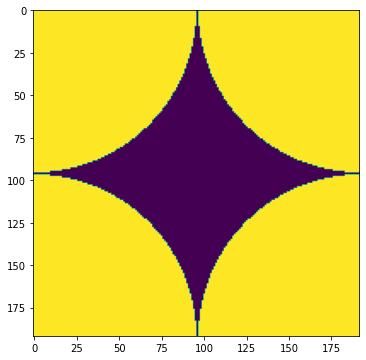

In [18]:
plt.imshow(create_3d_mask(x_grid, [0, 0, 0], res[-1])[0])

In [19]:
cond = []
cond0 = []

D_maxs = []
D_maxs0 = []

D_mins = []
D_mins0 = []

for r in tqdm(res):
    mask_3d = create_3d_mask(x_grid, [0, 0, 0], r)

    D_masked = D * mask_3d
    D_masked0 = D0 * mask_3d

    D_max = jnp.max(jnp.abs(D_masked))
    D_max0 = jnp.max(jnp.abs(D_masked0))

    D_min = jnp.min(jnp.abs(D_masked[D_masked > 0]))
    D_min0 = jnp.min(jnp.abs(D_masked0[D_masked0 > 0]))

    D_maxs.append(D_max)
    D_maxs0.append(D_max0)

    D_mins.append(D_min)
    D_mins0.append(D_min0)

    cond.append(D_max / D_min)
    cond0.append(D_max0 / D_min0)

100%|██████████| 96/96 [01:11<00:00,  1.33it/s]


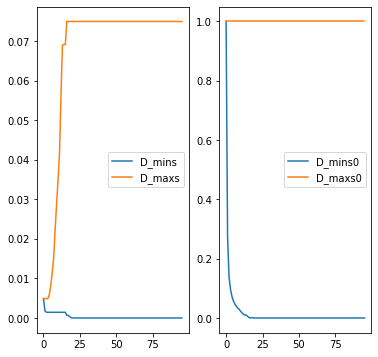

In [20]:
plt.subplot(121)
plt.plot(D_mins)
plt.plot(D_maxs)
plt.legend(["D_mins", "D_maxs"])

plt.subplot(122)
plt.plot(D_mins0)
plt.plot(D_maxs0)
plt.legend(["D_mins0", "D_maxs0"])

In [21]:
savefig = False

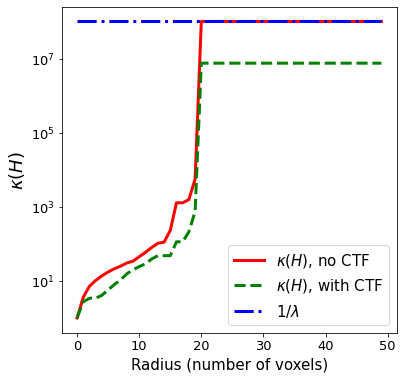

In [22]:
plot_range = 50
plt.semilogy(cond0[:plot_range], "r", linewidth=3)
plt.semilogy(cond[:plot_range], "g--", linewidth=3)
plt.semilogy(
    1 / alpha * jnp.ones((plot_range,)), "b-.", linewidth=3
)

plt.xticks(fontsize='13')
plt.yticks(fontsize="13")
plt.locator_params(axis="x", nbins=6)
plt.xlabel("Radius (number of voxels)", fontsize="15")
plt.ylabel("$\kappa(H)$", fontsize="18")
plt.legend(
    ["$\kappa(H)$, no CTF", "$\kappa(H)$, with CTF", "$1/\lambda$"], fontsize="15"
)


if savefig:
    plt.savefig(f"cond_number_empirical.eps", bbox_inches="tight")

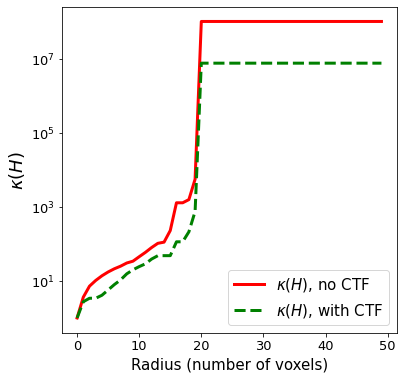

In [23]:
plot_range = 50

plt.semilogy(cond0[:plot_range], "r", linewidth=3)
plt.semilogy(cond[:plot_range], "g--", linewidth=3)

plt.xticks(fontsize='13')
plt.yticks(fontsize="13")
plt.locator_params(axis="x", nbins=6)
plt.xlabel("Radius (number of voxels)", fontsize="15")
plt.ylabel("$\kappa(H)$", fontsize="18")
plt.legend(
    ["$\kappa(H)$, no CTF", "$\kappa(H)$, with CTF", "Theoretical"], fontsize="15"
)


if savefig:
    plt.savefig(f"cond_number_empirical.eps", bbox_inches="tight")

In [38]:
savefig = False

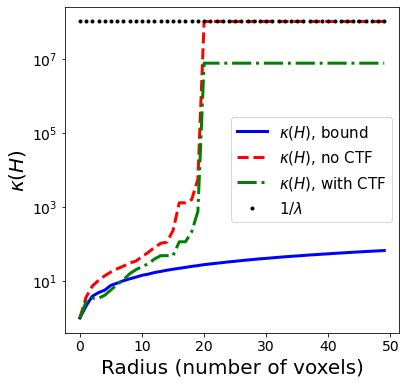

In [39]:
kr = (N + alpha) / (N*p + alpha)

plt.semilogy(kr[:plot_range], "b", linewidth=3)
plt.semilogy(cond0[:plot_range], "r--", linewidth=3)
plt.semilogy(cond[:plot_range], "g-.", linewidth=3)
plt.semilogy(1 / alpha * jnp.ones((plot_range,)), "k.", linewidth=3)

plt.xticks(fontsize="14")
plt.yticks(fontsize="14")
plt.xlabel("Radius (number of voxels)", fontsize="20")
plt.ylabel("$\kappa(H)$", fontsize="20")
plt.legend(
    [
        "$\kappa(H)$, bound",
        "$\kappa(H)$, no CTF",
        "$\kappa(H)$, with CTF",
        "$1/\lambda$",
    ],
    fontsize="15",
)

if savefig:
    plt.savefig(f"cond_number_empirical_vs_theoretical.eps")
    plt.savefig(f"cond_number_empirical_vs_theoretical_tight.eps", bbox_inches="tight")

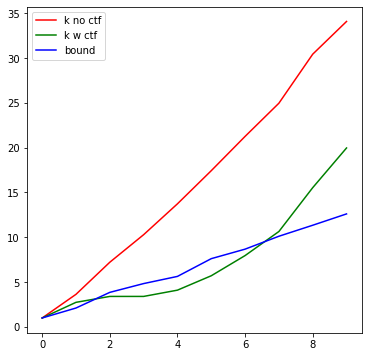

In [40]:
# A closer look at the plot above

upto = 10

plt.plot(jnp.array(cond0[:upto]), 'r')
plt.plot(jnp.array(cond[:upto]), 'g')
plt.plot(kr[:upto], 'b')
plt.legend(['k no ctf', 'k w ctf', 'bound'])

### Histogram of angles in the dataset

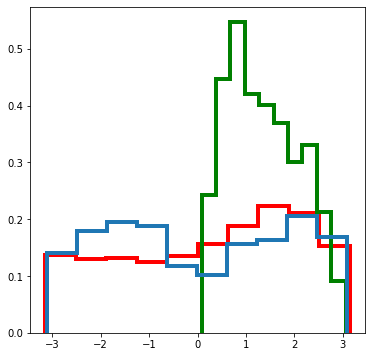

In [27]:
n_bins = 10

fig, ax = plt.subplots()
bins1, bin_edges1, _ = plt.hist(
    angles[:, 0], n_bins, density=True, histtype="step", color="r", alpha=1, linewidth=4
)
bins2, bin_edges2, _ = plt.hist(
    angles[:, 1], n_bins, density=True, histtype="step", color="g", alpha=1, linewidth=4
)
bins3, bin_edges3, _ = plt.hist(
    angles[:, 2], n_bins, density=True, histtype="step", alpha=1, linewidth=4
)

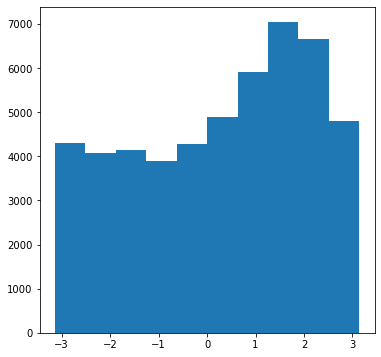

In [28]:
counts, bins = np.histogram(angles[:, 0], bins=n_bins)
_ = plt.hist(bins[:-1], bins, weights=counts)

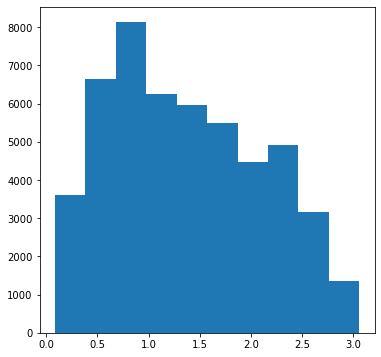

In [29]:
counts, bins = np.histogram(angles[:, 1], bins=n_bins)
_ = plt.hist(bins[:-1], bins, weights=counts)

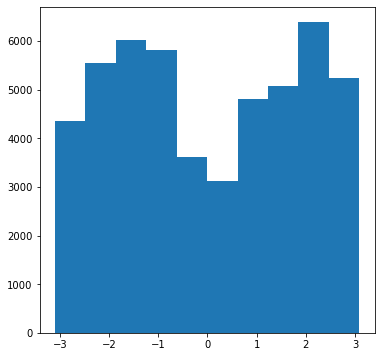

In [30]:
counts, bins = np.histogram(angles[:, 2], bins=n_bins)
_ = plt.hist(bins[:-1], bins, weights=counts)